### Load Packages

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# Import package for SMOTE
import imblearn

# Turn warnings off to keep notebook clean
import warnings
warnings.filterwarnings("ignore")

### Read CSV into Pandas DataFrame

In [80]:
data = pd.read_csv('data/processed_stroke.csv')
# Make all data 'float' type and drop ID
data = data.astype(float)
data.drop('id', axis=1, inplace=True) # Remove ID

### Record number in each class

In [81]:
# Record number in each class
number_stroke = np.sum(data['stroke'] == 1)
number_not_stroke = np.sum(data['stroke'] == 0)

### Divide into X (features) and y (labels)

In [82]:
X = data.drop('stroke',axis=1) # X = all 'data' except the 'stroke' column
y = data['stroke'] # y = 'stroke' column from 'data'

### Divide into training and test sets

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Show examples from the training data

In [84]:
X_train.head()

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown
384,0.0,1.0,0.0,56.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,205.26,40.3,0.0,0.0,1.0,0.0
1249,1.0,0.0,0.0,73.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,189.45,32.2,0.0,0.0,1.0,0.0
3420,0.0,1.0,0.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,79.94,36.6,0.0,0.0,0.0,1.0
1437,1.0,0.0,0.0,53.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,78.68,29.5,0.0,0.0,1.0,0.0
836,0.0,1.0,0.0,54.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,90.92,29.1,0.0,0.0,1.0,0.0


### Standardise data

In [85]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [86]:
X_train_std, X_test_std = standardise_data(X_train, X_test)

### Fit Logistic Regression model

In [87]:
model = LogisticRegression()
model.fit(X_train_std,y_train)

LogisticRegression()

### Use fitted model to make predictions on training and test set data

In [88]:
# Predict training and test set labels
y_pred_train = model.predict(X_train_std)
y_pred_test = model.predict(X_test_std)

### Calculate accuracy

In [89]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')

Accuracy of predicting training data = 0.959
Accuracy of predicting test data = 0.953


### Function to create synthetic data

In [90]:
def make_synthetic_data_smote(X, y, number_of_samples=[1000,1000]):
    """
    Synthetic data generation for two classes.
        
    Inputs
    ------
    original_data: X, y numpy arrays (y should have label 0 and 1)
    number_of_samples: number of samples to generate (list for y=0, y=1)
    (Note - number_of_samples has default of 1000 samples for each class
    if no numbers are specified at the point of calling the function)
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
    
    # import SMOTE from imblearn so we can use it
    from imblearn.over_sampling import SMOTE
    
    # Count instances in each class
    count_label_0 = np.sum(y==0)
    count_label_1 = np.sum(y==1)
    
    # SMOTE requires final class counts; add current counts to required counts
    # (which are passed into the function)
    n_class_0 = number_of_samples[0] + count_label_0
    n_class_1 = number_of_samples[1] + count_label_1

    # Use SMOTE to sample data points.  The number of points that we pass over
    # to SMOTE is calculated above (the number of synthetic data samples we
    # want, which we passed into the function + the counts from the original
    # data).  This tells SMOTE how many TOTAL data points are needed (original
    # + synthetic) for each class.  It then uses the original data to generate
    # new synthetic data points.
    # For example, imagine our original data has 100 samples for class 0 and 50
    # for class 1, and we tell SMOTE we want 100 synthetic data points for 
    # class 0 and 150 synthetic data points for class 1.  We tell SMOTE that we
    # need a total of 200 data points for class 0 (100 original + 100 synthetic)
    # and 200 data points for class 1 (50 original + 150 synthetic).  It will
    # then fill those data points by taking the original data (which will fill
    # up the first 100 "slots" for class 0, and the first 50 "slots" for class 1)
    # and then use these original data points to sample new synthetic data points
    # to fill the remaining "slots" in each class.
    X_resampled, y_resampled = SMOTE(
        sampling_strategy = {0:n_class_0, 1:n_class_1}).fit_resample(X, y)

    # Get just the additional (synthetic) data points.  By using len(X) for the
    # X (input feature) data, and len(y) for the y (output label) data, we skip
    # the original data, and just start from the newly created synthetic data,
    # generated by SMOTE (above)
    X_synthetic = X_resampled[len(X):]
    y_synthetic = y_resampled[len(y):]
                                                                   
    return X_synthetic, y_synthetic

### Generate raw synthetic data

In [91]:
# Get counts of classes from y_train
unique, original_frequency = np.unique(y_train, return_counts = True)
required_smote_count = list(original_frequency * 2)

In [92]:
# Call the function we wrote above to generate and extract the synthetic data
X_synthetic, y_synthetic = make_synthetic_data_smote(
        X_train, y_train, number_of_samples=required_smote_count)

### Prepare lists of categorical, integer and binary features

In [93]:
# Get full list of column names (the names of our features)
X_col_names = list(X_train)

# Set categorical one-hots cols using common prefix 
# First, let's set up the categorical columns, which we'll need to
# "one hot encode".  We've got two categorical features in the
# Titanic data - where they embarked, and their cabin letter.
# Here, we'll use some code to grab out all the categorical columns
# (remember, they're set up to be one hot encoded in the original data,
# so if there are three places from which a passenger can embark, then
# there are three columns for the embarked feature, and one of them will
# have a 1 value, whilst the others will have a 0 value.).
# We do this here by giving the common prefix (start of the name) of the
# columns we want, and then use a list comprehension to find all column
# names that start with that prefix, and store those in a list of one hot
# columns.  Remember, strings (such as the names of columns here) can be
# treated as lists of characters (so x[0] would give the first character)
# The list comprehension code below may look confusing initially, but it
# basically says "give me the column name if it starts with "Embarked_" or
# "CabinLetter_"
categorical = ['gender_', 'work_type_', 'smoking_status_']
one_hot_cols = []
for col in categorical:
    one_hot_cols.append([x for x in X_col_names if x[0:len(col)] == col])
    
# Set integer columns
integer_cols = ['age']

# Set binary columns
binary_cols = ['hypertension',
               'heart_disease',
               'ever_married',
               'residence_type_rural']

### Function to process raw synthetic categorical data to one-hot encoded

In [94]:
def make_one_hot(x):
    """
    Takes a list/array/series and turns it into a one-hot encoded
    list/array series, by setting 1 for highest value and 0 for all 
    others
    
    """
    # Get argmax (this returns the index of the highest values in
    # the list / array / series passed in to the function)
    highest = np.argmax(x)
    # Set all values to zero (just multiply all values by 0)
    x *= 0.0
    # Set the value that was found to be the highest to 1, by
    # using the index we found using argmax above
    x[highest] = 1.0
    
    return x

### Process raw synthetic data and show a sample

In [95]:
# Set y_label
y_label = 'stroke'

# Create a data frame with id to store the synthetic data
synth_df = pd.DataFrame()

# Transfer X values to the new DataFrame
synth_df=pd.concat([synth_df, 
                    pd.DataFrame(X_synthetic, columns=X_col_names)],
                    axis=1)

# Make columns (that need to be) one hot encoded using the
# function we wrote above, using the raw synthetic data
for one_hot_list in one_hot_cols:    
    for index, row in synth_df.iterrows():
        x = row[one_hot_list]
        x_one_hot = make_one_hot(x)
        row[x_one_hot.index]= x_one_hot.values

# Make integer as necessary by rounding the raw synthetic data
for col in integer_cols:
    synth_df[col] = synth_df[col].round(0)

# Round binary cols and clip so values under 0 or above 1
# are set to 0 and 1 respectively (this won't happen with
# SMOTE, as it will only sample between the two points (so 
# points sampled between binary points will always be 
# between 0 and 1) but it can happen with other methods)
for col in binary_cols:
    synth_df[col] = np.clip(synth_df[col],0,1).round(0)
    
# Add y data with a label
y_list = list(y_synthetic)
synth_df[y_label] = y_list

# Shuffle data
synth_df = synth_df.sample(frac=1.0)

In [96]:
synth_df.head()

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,work_type_children,work_type_never_worked,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown,stroke
10825,0.0,1.0,0.0,79.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,66.948254,22.861292,0.0,1.0,0.0,0.0,1.0
8251,1.0,0.0,0.0,57.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,76.616420,31.332716,0.0,1.0,0.0,0.0,0.0
10637,0.0,1.0,0.0,65.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,82.847835,28.305322,0.0,1.0,0.0,0.0,0.0
5222,0.0,1.0,0.0,60.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,75.724904,29.426145,0.0,1.0,0.0,0.0,0.0
3708,0.0,1.0,0.0,59.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,77.599206,23.336470,0.0,0.0,0.0,1.0,0.0


### Find nearest original data point to each synthetic data point

In [97]:
# Standardise synthetic data (based on real training data)
X_train_std, X_synth_std = standardise_data(X_train, X_synthetic)

# Get ALL real X data (combine standardised training + test data)
# We do this because we need to check for duplicates / very close
# values in all of the real data we've got
X_real_std = np.concatenate([X_train_std, X_test_std], axis=0)
  
# Use SciKitLearn neighbors.NearestNeighbors to find nearest neighbour
# to each data point. First, we fit to the real standardised data 
# (all of it, train + test set).  Then we can give it the synthetic data
# and ask it to give us the cartesian distance and ID of its nearest
# real world data point neighbour for each synthetic data point.
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X_real_std)
dists, idxs = nn.kneighbors(X_synth_std)

# Store the index and ids (indices) in the synthetic data DataFrame
# Flatten just reduces something in more than 1 dimension down to
# 1 dimension (eg a list of lists becomes a single list)
synth_df['distance_to_closest_real'] = list(dists.flatten())
synth_df['closest_X_real_row_index'] = list(idxs.flatten())

In [98]:
synth_df

,gender_male,gender_female,gender_other,age,hypertension,heart_disease,ever_married,work_type_private,work_type_self_employed,work_type_govt_job,...,residence_type_rural,avg_glucose_level,bmi,smoking_status_smokes,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_unknown,stroke,distance_to_closest_real,closest_X_real_row_index
10825,0.0,1.0,0.0,79.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,66.948254,22.861292,0.0,1.0,0.0,0.0,1.0,3.072544,2125
8251,1.0,0.0,0.0,57.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,76.616420,31.332716,0.0,1.0,0.0,0.0,0.0,1.629661,1844
10637,0.0,1.0,0.0,65.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,82.847835,28.305322,0.0,1.0,0.0,0.0,0.0,3.171653,2928
5222,0.0,1.0,0.0,60.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,75.724904,29.426145,0.0,1.0,0.0,0.0,0.0,1.592292,3512
3708,0.0,1.0,0.0,59.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,77.599206,23.336470,0.0,0.0,0.0,1.0,0.0,0.677944,3572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10309,1.0,0.0,0.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,72.157566,22.200000,0.0,0.0,0.0,1.0,0.0,1.226343,448
4218,0.0,1.0,0.0,19.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,127.709769,25.135415,0.0,0.0,0.0,1.0,0.0,1.803446,2716
4456,1.0,0.0,0.0,23.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,61.495958,25.572864,0.0,1.0,0.0,0.0,0.0,2.608036,584
8202,0.0,1.0,0.0,51.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,95.699533,24.799542,0.0,1.0,0.0,0.0,0.0,2.420400,4603


### Remove identical points

In [99]:
# Get points with zero distance to real (use distance of <0.001 as effectively identical)
identical = synth_df['distance_to_closest_real'] < 0.001

print (f'Proportion of data points identical to real data points = {identical.mean():0.3f}')
# Remove points with zero (or effectively zero) distance to a real data point.  We
# do this by setting up a mask that says we only want to see data points where the "identical"
# criterion we specified above is false (ie they're not identical).  Then we apply that
# mask and overwrite our existing synthetic data DataFrame so we've now only got data points
# that are not identical to real world data points.
mask = identical == False
synth_df = synth_df[mask]

Proportion of data points identical to real data points = 0.002


### Remove points closest to original data

In [100]:
# Proportion of points to remove
proportion_to_remove = 0.1

# Sort by distance, with highest distances (those we want to keep) at 
# the top
synth_by_distance = synth_df.sort_values(
    'distance_to_closest_real', ascending=False)

# Limit data.  Calculate the number of entries to keep as being the
# total number of synthetic data points we've now got (after having
# removed ones identical to real world data points) multiplied by
# the proportion we want to keep (the inverse of the proportion to remove).
# As we've sorted in descending order by distance, we can then just
# use .head to identify how much of the top of list we want to keep
# (90% in this case, where we're removing the 10% that are closest - at
# the bottom)
number_to_keep = int(len(synth_by_distance) * (1 - proportion_to_remove))
synth_by_distance = synth_by_distance.head(number_to_keep)

# Shuffle and store back in synth_df (frac=1 gives us a sample size of 100%
# (ie - all of the ones we said above we wanted to keep))
synth_df = synth_by_distance.sample(frac=1)

### Show five examples with their closest data points in the original data

In [101]:
# Reproduce X_real but with non-standardised (ie the raw original) values for 
# comparison
X_real = np.concatenate([X_train, X_test], axis=0)

# Set up Data Frame for comparison
comparison = pd.DataFrame(index=X_col_names)

# Generate five examples
for i in range(5):
    # Get synthetic data sample (sample size of 1 - one data point)
    sample = synth_df.sample(1)
    comparison[f'Synthetic_{i+1}'] = sample[X_col_names].values[0]
    # Get closest point from the real data (remember we stored earlier
    # the index of the closest real world point, so we can grab it out
    # easily here)
    closest_id = sample['closest_X_real_row_index']
    comparison[f'Synthetic_{i+1}_closest'] = X_real[closest_id, :][0]
    
# Display the comparisons
comparison.round(0)

,Synthetic_1,Synthetic_1_closest,Synthetic_2,Synthetic_2_closest,Synthetic_3,Synthetic_3_closest,Synthetic_4,Synthetic_4_closest,Synthetic_5,Synthetic_5_closest
gender_male,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
gender_female,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
gender_other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
age,65.0,2.0,58.0,75.0,22.0,22.0,62.0,76.0,69.0,68.0
hypertension,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ever_married,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
work_type_private,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
work_type_self_employed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
work_type_govt_job,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Sample from synthetic data to get same size / balance as the original data, and compare counts to ensure identical to original data

In [102]:
# Randomly sample from the synthetic data those who died,
# and sample this the same number of times as we had number
# who died in the real data
mask = synth_df['stroke'] == 0
synth_not_stroke = synth_df[mask].sample(number_not_stroke)

# The same as above, but for those who survived
mask = synth_df['stroke'] == 1
synth_stroke = synth_df[mask].sample(number_stroke)

# Reconstruct into synth_df and shuffle
synth_df = pd.concat([synth_not_stroke, synth_stroke], axis=0)
synth_df = synth_df.sample(frac=1.0, )

In [103]:
print ('Number of real data stroke: ', np.sum(data['stroke'] == 1))
print ('Number of synthetic data stroke: ', np.sum(synth_df['stroke'] == 1))
print ('Number of real data not stroke: ', np.sum(data['stroke'] == 0))
print ('Number of synthetic not stroke: ', np.sum(synth_df['stroke'] == 0))

Number of real data stroke:  209
Number of synthetic data stroke:  209
Number of real data not stroke:  4700
Number of synthetic not stroke:  4700


### Compare real and synthetic data using plots

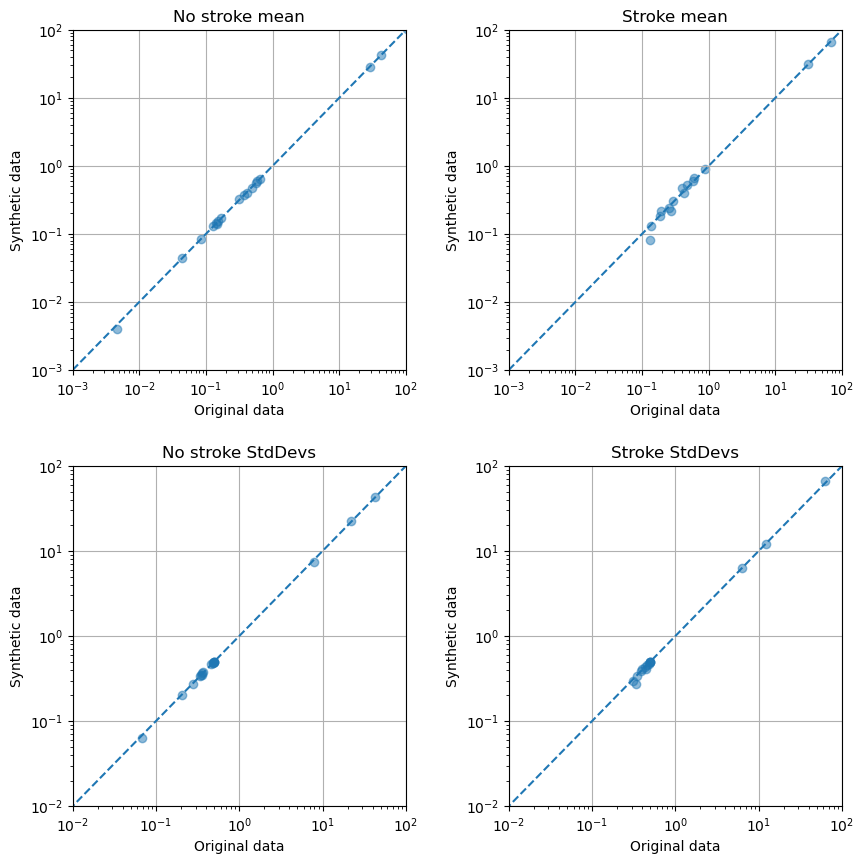

In [104]:
fig = plt.figure(figsize=(9,9))

# Compare means of patients who didn't have stroke
ax1 = fig.add_subplot(221)
mask = data['stroke'] == 0
x = data[mask][X_col_names].mean()
mask = synth_df['stroke'] == 0
y = synth_df[mask][X_col_names].mean()
ax1.scatter(x,y, alpha=0.5)
ax1.plot([0.001, 100],[0.001,100], linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-3, 1e2)
ax1.set_ylim(1e-3, 1e2)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_title('No stroke mean')
ax1.grid()

# Compare means of patients who had stroke
ax2 = fig.add_subplot(222)
mask = data['stroke'] == 1
x = data[mask][X_col_names].mean()
mask = synth_df['stroke'] == 1
y = synth_df[mask][X_col_names].mean()
ax2.scatter(x,y, alpha=0.5)
ax2.plot([0.001, 100],[0.001,100], linestyle='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e-3, 1e2)
ax2.set_ylim(1e-3, 1e2)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Stroke mean')
ax2.grid()

# Compare stdevs of patients who didn't have stroke
ax3 = fig.add_subplot(223)
mask = data['stroke'] == 0
x = data[mask][X_col_names].std()
mask = synth_df['stroke'] == 0
y = synth_df[mask][X_col_names].std()
ax3.scatter(x,y, alpha=0.5)
ax3.plot([0.001, 100],[0.001,100], linestyle='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1e-2, 1e2)
ax3.set_ylim(1e-2, 1e2)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('No stroke StdDevs')
ax3.grid()

# Compare stdevs of patients who had stroke
ax4 = fig.add_subplot(224)
mask = data['stroke'] == 1
x = data[mask][X_col_names].std()
mask = synth_df['stroke'] == 1
y = synth_df[mask][X_col_names].std()
ax4.scatter(x,y, alpha=0.5)
ax4.plot([0.001, 100],[0.001,100], linestyle='--')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlim(1e-2, 1e2)
ax4.set_ylim(1e-2, 1e2)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Stroke StdDevs')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('images/smote_correls.png', facecolor='w', dpi=300)
plt.show()

### Fit Logistic Regression model using synthetic data and compare accuracy with model trained on original data

In [105]:
# Get X data and standardised
X_synth = synth_df[X_col_names]
y_synth = synth_df['stroke'].values
X_synth_std, X_test_std = standardise_data(X_synth, X_test)

# Fit model
model_synth = LogisticRegression()
model_synth.fit(X_synth_std,y_synth)

# Get predictions of test set
y_pred_test_synth = model_synth.predict(X_test_std)

# Report accuracy
accuracy_test_synth = np.mean(y_pred_test_synth == y_test)

print (f'Accuracy of predicting test data from model trained on real data = {accuracy_test:0.3f}')
print (f'Accuracy of predicting test data from model trained on synthetic data = {accuracy_test_synth:0.3f}')

Accuracy of predicting test data from model trained on real data = 0.953
Accuracy of predicting test data from model trained on synthetic data = 0.953


### ROC Curves

In [106]:
y_probs = model.predict_proba(X_test_std)[:,1]
y_probs_synthetic = model_synth.predict_proba(X_test_std)[:,1]

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fpr_synth, tpr_synth, thresholds_synth = roc_curve(y_test, y_probs_synthetic)
roc_auc = auc(fpr, tpr)
roc_auc_snth = auc(fpr_synth, tpr_synth)
print (f'ROC AUC real training data: {roc_auc:0.2f}')
print (f'ROC AUC synthetic training data: {roc_auc_snth:0.2f}')

ROC AUC real training data: 0.84
ROC AUC synthetic training data: 0.83


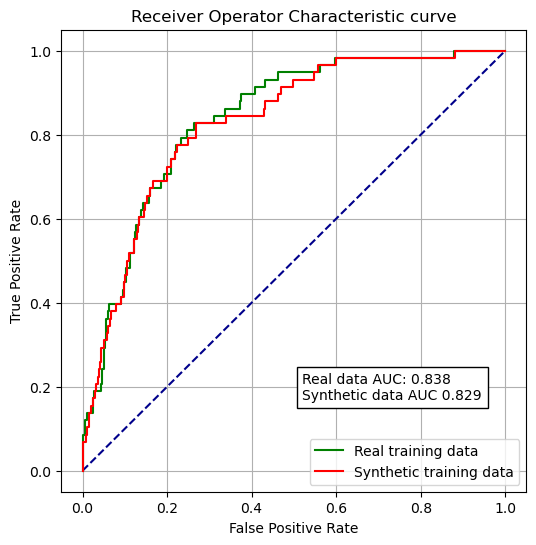

In [108]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic curve')
ax1.plot(fpr,tpr, color='green', label = 'Real training data')
ax1.plot(fpr_synth,tpr_synth, color='red', label = 'Synthetic training data')
text = f'Real data AUC: {roc_auc:.3f}\nSynthetic data AUC {roc_auc_snth:.3f}'
ax1.text(0.52,0.17, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.legend()
plt.grid(True)

plt.savefig('images/synthetic_roc.png')
plt.show()